# Things to do
    - add humidity column
    - add weekday column
    - one hot encoder cbwd and weekday columns
    - fill NaN with not NaN before
    - outliers
    - add past data columns

### Rút kinh nghiệm sau vài lần chọn features cho model:  
    - Cột cbwd và thứ trong tuần không quá ảnh hưởng đến model nên không dùng nữa
    - Cột Ir và Is không ảnh hưởng nhiều đến model
    - Cột pres không ảnh hưởng nhiều dến model

- Thử phương pháp vét cạn, chọn trường hợp tối ưu nhất trong số tất cả cách chọn -> 2^(số cột)

In [1]:
import pandas as pd
import numpy as np
from math import exp, isnan
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams["figure.figsize"] = 15, 10

In [3]:
df = pd.read_csv('data.csv')
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


## Add humidity column

In [4]:
def cal(temp, dewp):
    return 100*(exp((17.625*dewp)/(243.04+dewp))/exp((17.625*temp)/(243.04+temp)))
df['hum'] = [cal(temp, dewp) for temp, dewp in zip(df['TEMP'], df['DEWP'])]

## Add weekday column

In [5]:
# weekday = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
# tmp = []
# for i, j, k in zip(df['day'], df['month'], df['year']):
#     date = weekday[datetime.strptime(str('{}/{}/{}'.format(i, j, k)), '%d/%m/%Y').weekday()]
#     tmp.append(date)
# df['weekday'] = tmp

## One Hot Encoder cbwd column

In [6]:
# df = pd.get_dummies(df)

## Fill NaN with not NaN before

In [7]:
df['pm2.5'].isna().sum()

2067

In [8]:
df['pm2.5'].fillna(method='ffill', inplace=True)

In [9]:
df.dropna(inplace=True)

## Outliers

In [10]:
dic = {}
for day, month, year, hour, pm25 in zip(df['day'], df['month'], df['year'], df['hour'], df['pm2.5']):
    dic[datetime.strptime(str('{}/{}/{} {}:00'.format(int(day), int(month), int(year), int(hour))), '%d/%m/%Y %H:%M')] = pm25

In [11]:
outlier_df = pd.DataFrame.from_dict(dic, orient='index', columns=['Value'])

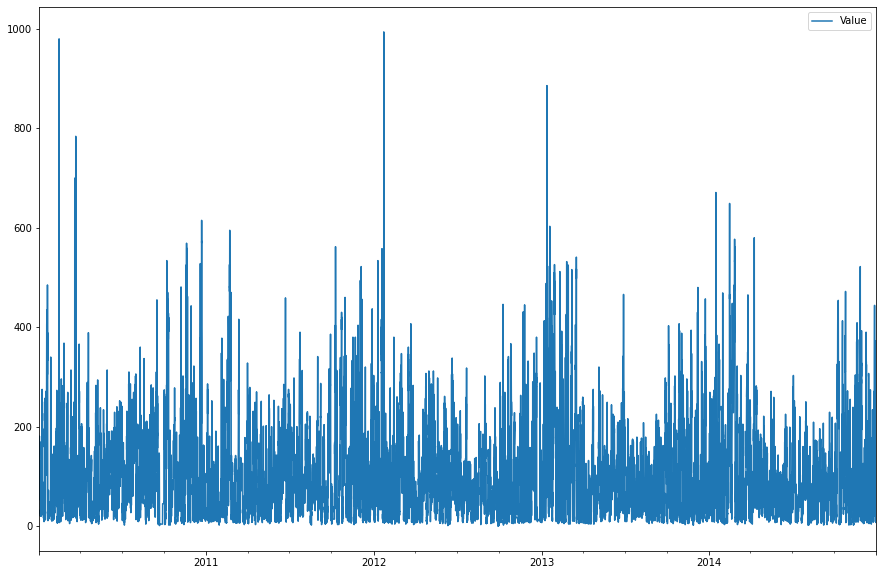

In [12]:
outlier_df.plot()
plt.show()

In [13]:
df = df[df['pm2.5'] <= 600]

In [14]:
df.corr()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,hum
No,1.000000,0.979818,0.198630,0.017443,0.000583,-0.009528,0.046393,0.077008,-0.024573,-0.062673,-0.029568,-0.016719,-0.013252
year,0.979818,1.000000,-0.000573,-0.001077,0.000154,-0.006876,0.000151,0.044835,-0.013069,-0.064370,-0.017062,-0.024493,-0.050575
month,0.198630,-0.000573,1.000000,0.009206,-0.000582,-0.021266,0.232543,0.167881,-0.061513,0.002493,-0.061901,0.036541,0.180682
day,0.017443,-0.001077,0.009206,1.000000,0.000052,0.081097,0.027328,0.013326,-0.006913,-0.009141,-0.036920,0.002559,0.028218
hour,0.000583,0.000154,-0.000582,0.000052,1.000000,-0.023593,-0.021267,0.150029,-0.041671,0.056610,-0.002391,-0.006322,-0.256729
pm2.5,-0.009528,-0.006876,-0.021266,0.081097,-0.023593,1.000000,0.183443,-0.071875,-0.061710,-0.246062,0.020398,-0.049038,0.440030
DEWP,0.046393,0.000151,0.232543,0.027328,-0.021267,0.183443,1.000000,0.824458,-0.778787,-0.297034,-0.034532,0.125006,0.622290
TEMP,0.077008,0.044835,0.167881,0.013326,0.150029,-0.071875,0.824458,1.000000,-0.827405,-0.155456,-0.092869,0.048932,0.095473
PRES,-0.024573,-0.013069,-0.061513,-0.006913,-0.041671,-0.061710,-0.778787,-0.827405,1.000000,0.185625,0.069082,-0.079816,-0.256052
Iws,-0.062673,-0.064370,0.002493,-0.009141,0.056610,-0.246062,-0.297034,-0.155456,0.185625,1.000000,0.021856,-0.010180,-0.309699


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


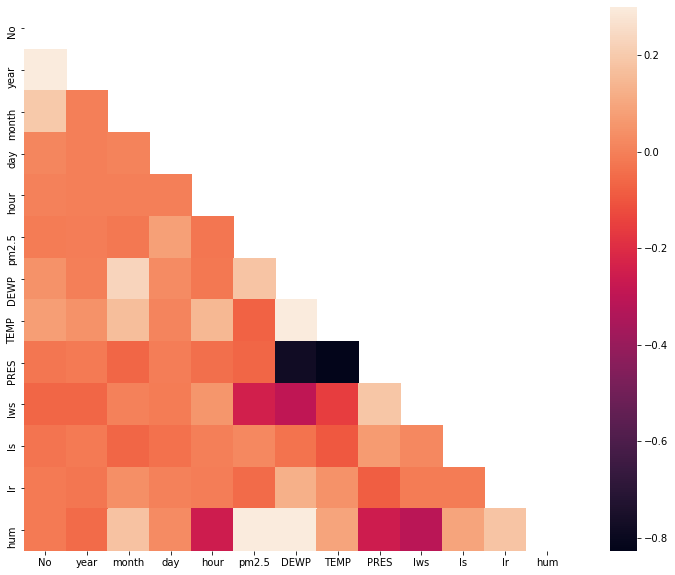

In [15]:
import seaborn as sns
data = df.corr()
mask = np.zeros_like(data)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(data, mask=mask, vmax=.3, square=True)

In [16]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,hum
No,1.000000,0.979818,0.198630,0.017443,0.000583,-0.009528,0.046393,0.077008,-0.024573,-0.062673,-0.029568,-0.016719,-0.013252
year,0.979818,1.000000,-0.000573,-0.001077,0.000154,-0.006876,0.000151,0.044835,-0.013069,-0.064370,-0.017062,-0.024493,-0.050575
month,0.198630,-0.000573,1.000000,0.009206,-0.000582,-0.021266,0.232543,0.167881,-0.061513,0.002493,-0.061901,0.036541,0.180682
day,0.017443,-0.001077,0.009206,1.000000,0.000052,0.081097,0.027328,0.013326,-0.006913,-0.009141,-0.036920,0.002559,0.028218
hour,0.000583,0.000154,-0.000582,0.000052,1.000000,-0.023593,-0.021267,0.150029,-0.041671,0.056610,-0.002391,-0.006322,-0.256729
pm2.5,-0.009528,-0.006876,-0.021266,0.081097,-0.023593,1.000000,0.183443,-0.071875,-0.061710,-0.246062,0.020398,-0.049038,0.440030
DEWP,0.046393,0.000151,0.232543,0.027328,-0.021267,0.183443,1.000000,0.824458,-0.778787,-0.297034,-0.034532,0.125006,0.622290
TEMP,0.077008,0.044835,0.167881,0.013326,0.150029,-0.071875,0.824458,1.000000,-0.827405,-0.155456,-0.092869,0.048932,0.095473
PRES,-0.024573,-0.013069,-0.061513,-0.006913,-0.041671,-0.061710,-0.778787,-0.827405,1.000000,0.185625,0.069082,-0.079816,-0.256052
Iws,-0.062673,-0.064370,0.002493,-0.009141,0.056610,-0.246062,-0.297034,-0.155456,0.185625,1.000000,0.021856,-0.010180,-0.309699


In [17]:
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,hum
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,38.784785
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,42.130158
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,62.793843
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,85.857955
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,85.857955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0,18.340886
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0,21.568601
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0,21.568601
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0,23.240409


## Add past data columns

In [18]:
need_shift = ['pm2.5', 'DEWP', 'TEMP', 'Iws']
for var in need_shift:
    for i in range(1, 3):
        key = var + '_' + str(i)
        df[key] = df[var].shift(periods=i)
df.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
df.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir', 'hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1',
       'DEWP_2', 'TEMP_1', 'TEMP_2', 'Iws_1', 'Iws_2'],
      dtype='object')

In [20]:
features_1 = list(df.columns[10:])
predicts = list(df.columns[5:8])

In [21]:
print(features_1)

['Iws', 'Is', 'Ir', 'hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'DEWP_2', 'TEMP_1', 'TEMP_2', 'Iws_1', 'Iws_2']


In [22]:
X = df[features_1]
y = df[predicts].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=1/4)

In [23]:
def cal_error(model, X, y):
    predict = model.predict(X)
    data = [0] * 3
    for i in range(len(predict)):
        for j in range(3):
            data[j] += abs(predict[i][j] - y[i][j])
    for i in range(3):
        data[i] /= len(predict)
    return (data[0], data[1], data[2])

In [24]:
def score_model(model, X, y):
    predict = model.predict(X)
    print('R^2 score:', r2_score(predict, y))
    print('Mean Absolute Error:', mean_absolute_error(predict, y))
    print('Error model:', cal_error(model, X, y))

In [25]:
def important_features(model, features):
    foo = pd.Series(model.feature_importances_, index=features)
    foo.nlargest(100).plot(kind='barh')
    plt.style.use('ggplot')
    plt.show()

## Modeling

In [26]:
random_forest = RandomForestRegressor() 
random_forest.fit(Xtrain, ytrain)
random_forest.score(Xtrain, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9919501415048898

In [27]:
score_model(random_forest, Xtest, ytest)

R^2 score: 0.970449579117564
Mean Absolute Error: 4.814111446241987
Error model: (12.443401882826095, 0.9237226944520671, 1.0752097614478007)


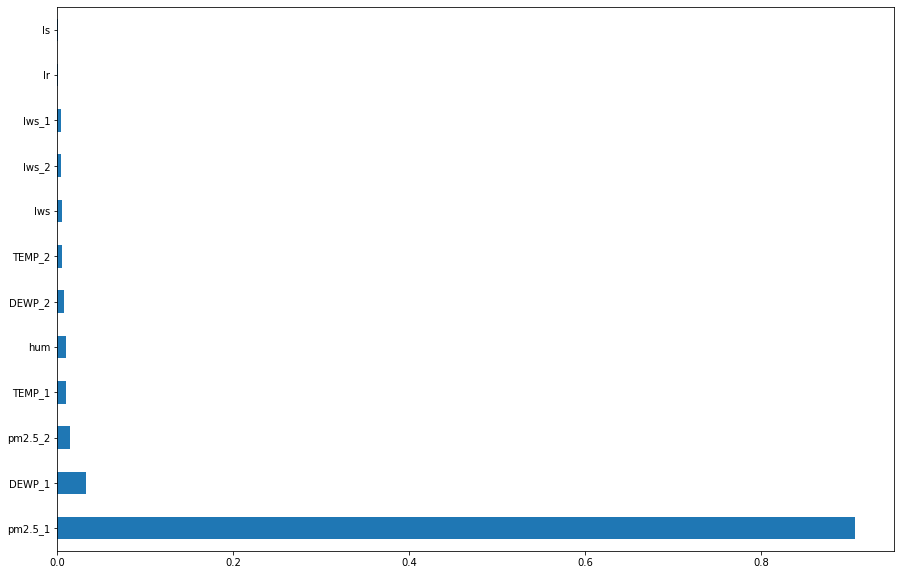

In [28]:
important_features(random_forest, features_1)

In [29]:
remove_list = ['cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'weekday_Fri', 
                 'weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thu', 
                'weekday_Tue', 'weekday_Wed']
features_2 = [i for i in features_1 if i not in remove_list]

In [30]:
X = df[features_2]
y = df[predicts].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=1/4)

In [31]:
random_forest_2 = RandomForestRegressor()
random_forest_2.fit(Xtrain, ytrain)
random_forest_2.score(Xtrain, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9919551197588751

In [32]:
score_model(random_forest_2, Xtest, ytest)

R^2 score: 0.9704446064547184
Mean Absolute Error: 4.794235647767313
Error model: (12.393937482862606, 0.9212412028151045, 1.0675282576242273)


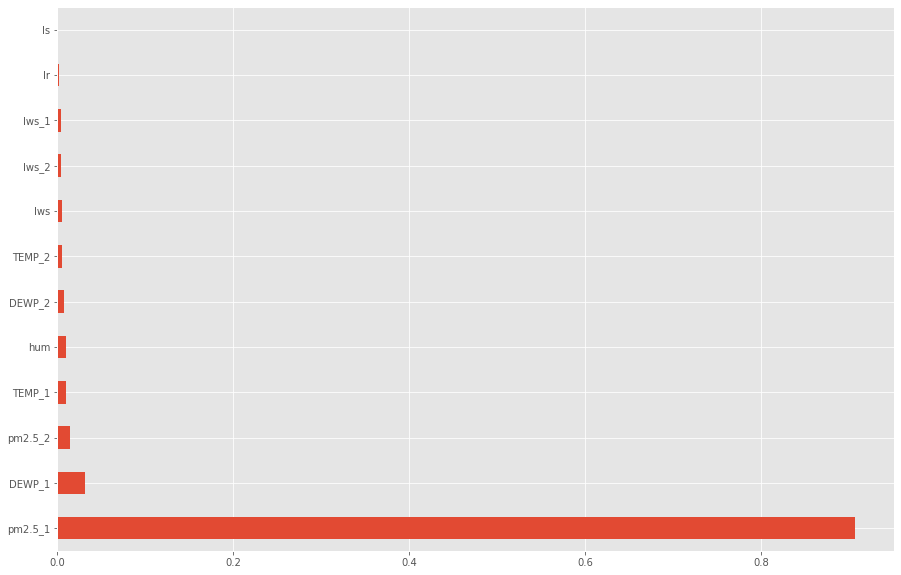

In [33]:
important_features(random_forest_2, features_2)

In [34]:
remove_list = ['Iws_2', 'Iws_1', 'Is', 'Ir', 'Iws']
features_3 = [i for i in features_2 if i not in remove_list]

In [35]:
X = df[features_3]
y = df[predicts].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=1/4)

In [36]:
random_forest_3 = RandomForestRegressor()
random_forest_3.fit(Xtrain, ytrain)
random_forest_3.score(Xtrain, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9918430847557551

In [37]:
score_model(random_forest_3, Xtest, ytest)

R^2 score: 0.9702283742319979
Mean Absolute Error: 4.923499791812667
Error model: (12.980481704902045, 0.8304588246047052, 0.9595588459312493)


In [38]:
features_3

['hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'DEWP_2', 'TEMP_1', 'TEMP_2']

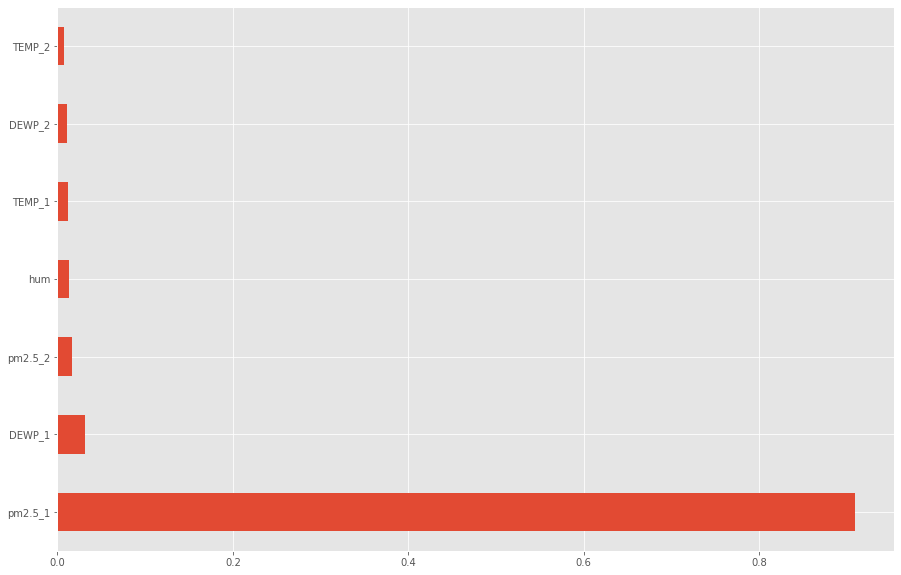

In [39]:
important_features(random_forest_3, features_3)

In [40]:
features_4 = ['pm2.5_1', 'pm2.5_2', 'TEMP_1', 'DEWP_1', 'Iws', 'hum']
X = df[features_4]
y = df[predicts].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=1/4)

In [41]:
random_forest_4 = RandomForestRegressor()
random_forest_4.fit(Xtrain, ytrain)
random_forest_4.score(Xtrain, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9916458296784774

In [42]:
score_model(random_forest_4, Xtest, ytest)

R^2 score: 0.9707628165940679
Mean Absolute Error: 4.821990281205263
Error model: (12.570735764555362, 0.8764160192547908, 1.0188190598056373)


In [43]:
features = features_1 + ['PRES']

In [48]:
best = 0
best_features = []

In [50]:
y = df[predicts]
for mask in range(1, 2 ** len(features)):
    lst = []
    for i in range(len(features)):
        if (mask & i):
            lst.append(features[i])
    if not lst:
      continue
    Xtrain, Xtest, ytrain, ytest = train_test_split(df[lst], y, test_size=1/4)
    random_forest = RandomForestRegressor()
    random_forest.fit(Xtrain, ytrain)
    predict = random_forest.predict(Xtest)
    score = r2_score(predict, ytest)
    if (score > best):
      best = score
      best_features = lst
      print(best, best_features)

0.9420468414110129 ['Is', 'hum', 'pm2.5_2', 'DEWP_2', 'TEMP_2', 'Iws_2']
0.9466803592057437 ['Is', 'Ir', 'hum', 'pm2.5_2', 'DEWP_1', 'DEWP_2', 'TEMP_2', 'Iws_1', 'Iws_2']
0.9662736151935647 ['Is', 'hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'DEWP_2', 'TEMP_2', 'Iws_2', 'PRES']
0.9663414735138854 ['Ir', 'hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'DEWP_2', 'Iws_1', 'Iws_2', 'PRES']
0.9692293428406525 ['Is', 'Ir', 'hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'DEWP_2', 'TEMP_2', 'Iws_1', 'Iws_2', 'PRES']
0.970019580571435 ['Is', 'hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'DEWP_2', 'TEMP_1', 'TEMP_2', 'Iws_1', 'Iws_2', 'PRES']
0.9706548618428354 ['Ir', 'hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'DEWP_2', 'TEMP_1', 'TEMP_2', 'Iws_1', 'Iws_2', 'PRES']
0.9709944316859005 ['Is', 'hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'DEWP_2', 'TEMP_1', 'TEMP_2', 'Iws_1', 'Iws_2', 'PRES']
0.9727184860037003 ['Is', 'Ir', 'hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'DEWP_2', 'TEMP_1', 'TEMP_2', 'Iws_1', 'Iws_2', 'PRES']


KeyboardInterrupt: ignored

In [51]:
final_features = ['Is', 'Ir', 'hum', 'pm2.5_1', 'pm2.5_2', 'DEWP_1', 'DEWP_2', 'TEMP_1', 'TEMP_2', 'Iws_1', 'Iws_2', 'PRES']

In [56]:
X = df[final_features]
y = df[predicts].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=1/3)

In [57]:
final_model = RandomForestRegressor()
final_model.fit(Xtrain, ytrain)
final_model.score(Xtrain, ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.9915815611378642

In [58]:
score_model(final_model, Xtest, ytest)

R^2 score: 0.9708354894314309
Mean Absolute Error: 4.808856442128982
Error model: (12.4150520976144, 0.9393892240197477, 1.0721280047528)


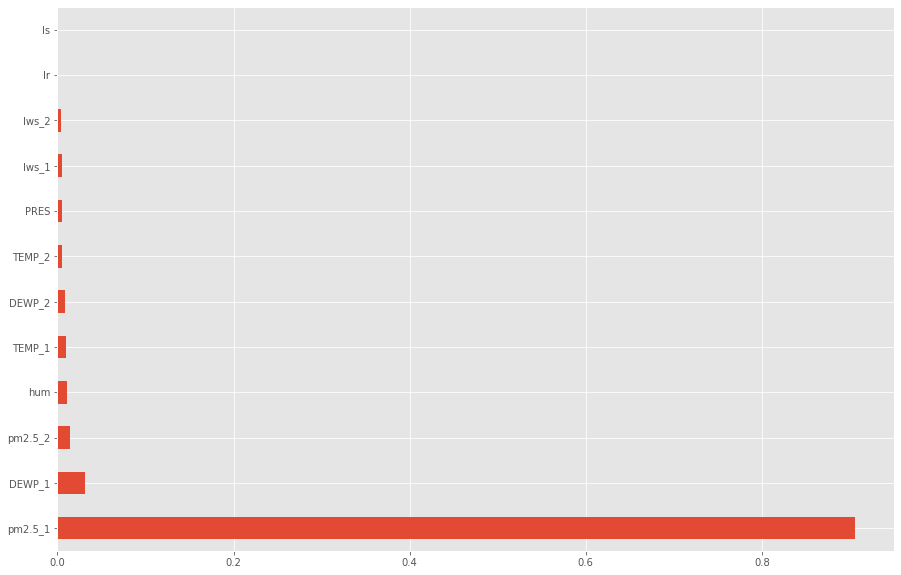

In [59]:
important_features(final_model, final_features)

## Predict for next 6 hours

In [60]:
for i in range(6):
    tail = pd.concat([df.tail(1)], ignore_index=True)
    tail.loc[:, ['day', 'month', 'year', 'hour']] = [1, 1, 2015, i]
    df = pd.concat([df, tail], ignore_index=True)
    df.loc[len(df) - 1:, predicts] = random_forest_3.predict(tail[features_3])
    for var in need_shift:
        for i in range(1, 3):
            key = var + '_' + str(i)
            df[key] = df[var].shift(periods=i)

In [61]:
df.tail(6)[['day', 'month', 'year', 'hour'] + predicts]

,day,month,year,hour,pm2.5,DEWP,TEMP
43763,1,1,2015,0,10.580000,-21.25,-3.29
43764,1,1,2015,1,13.880000,-21.27,-3.47
43765,1,1,2015,2,11.963333,-21.35,-3.42
43766,1,1,2015,3,13.680000,-21.12,-3.44
43767,1,1,2015,4,12.600000,-21.30,-3.41
43768,1,1,2015,5,13.810000,-21.10,-3.33


- season
- trend
- statistical models for time serries
- how data transform by times (up or down, low or high)
- past data for weekdays or for pm2.5 last year
- k fold cross validation for time series